In [1]:
import cv2
import os
import mediapipe as mp
import pandas as pd
from scipy.signal import find_peaks, argrelmin
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [2]:
class PoseEstimationModel:
    
    def __init__(self, path):
        self.video_path = path
        self.mp_drawing = mp.solutions.drawing_utils
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(min_detection_confidence=0.6, min_tracking_confidence=0.6)
        self.cap = cv2.VideoCapture(path)
        
    def display_video_with_keypoints(self):

        while self.cap.isOpened():
            _, frame = self.cap.read()

            try:
                RGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                results = self.pose.process(RGB)

                if results.pose_landmarks is not None:
                    keypoints_labels = {
                        self.mp_pose.PoseLandmark.LEFT_ANKLE: 'LEFT ANKLE',
                        self.mp_pose.PoseLandmark.RIGHT_ANKLE: 'RIGHT ANKLE',
                    }

                    for landmark in self.mp_pose.PoseLandmark:
                        if landmark in keypoints_labels.keys():
                            landmark_index = landmark.value
                            landmark_name = keypoints_labels[landmark]
                            data_point = results.pose_landmarks.landmark[landmark_index]
                            x = data_point.x * frame.shape[1]  
                            y = data_point.y * frame.shape[0]  

                            # Draw a label near the keypoint
                            cv2.putText(frame, f"{landmark_name}", (int(x), int(y) - 10),
                                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

                # Draw detected skeleton on the frame
                self.mp_drawing.draw_landmarks(
                    frame, results.pose_landmarks, self.mp_pose.POSE_CONNECTIONS)

                # Show the final output
                cv2.imshow('Output', frame)

            except:
                break

            if cv2.waitKey(1) == ord('q'):
                break

        self.cap.release()
        cv2.destroyAllWindows()
        
    def create_keypoint_dataframe(self): 

        time = []

        right_ankle_x = []
        right_ankle_y = []

        left_ankle_x = []
        left_ankle_y = []

        right_heel_x = []
        right_heel_y = []

        left_heel_x = []
        left_heel_y = []

        right_knee_x = []
        right_knee_y = []

        left_knee_x = []
        left_knee_y = []

        right_foot_index_x = []
        right_foot_index_y = []

        left_foot_index_x = []
        left_foot_index_y = []

        right_hip_x = []
        left_hip_x = []

        left_shoulder_x = []
        right_shoulder_x = []

        while self.cap.isOpened():
            _, frame = self.cap.read()

            try:
                RGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                results = self.pose.process(RGB)

                if results.pose_landmarks is not None:
                    keypoints_labels = {
                        self.mp_pose.PoseLandmark.LEFT_ANKLE,
                        self.mp_pose.PoseLandmark.LEFT_KNEE,
                        self.mp_pose.PoseLandmark.LEFT_HEEL,
                        self.mp_pose.PoseLandmark.LEFT_FOOT_INDEX,
                        self.mp_pose.PoseLandmark.LEFT_HIP,
                        self.mp_pose.PoseLandmark.LEFT_SHOULDER,

                        self.mp_pose.PoseLandmark.RIGHT_ANKLE,
                        self.mp_pose.PoseLandmark.RIGHT_KNEE,
                        self.mp_pose.PoseLandmark.RIGHT_HEEL,
                        self.mp_pose.PoseLandmark.RIGHT_FOOT_INDEX,
                        self.mp_pose.PoseLandmark.RIGHT_HIP,
                        self.mp_pose.PoseLandmark.RIGHT_SHOULDER,
                    }

                    time.append(self.cap.get(cv2.CAP_PROP_POS_MSEC))

                    for landmark in self.mp_pose.PoseLandmark:
                        if landmark in keypoints_labels:
                            landmark_index = landmark.value
                            data_point = results.pose_landmarks.landmark[landmark_index]
                            x = data_point.x * frame.shape[1] 
                            y = data_point.y * frame.shape[0]  

                            if landmark == self.mp_pose.PoseLandmark.RIGHT_ANKLE:
                                right_ankle_x.append(int(x))
                                right_ankle_y.append(int(y))

                            elif landmark == self.mp_pose.PoseLandmark.LEFT_ANKLE:
                                left_ankle_x.append(int(x))
                                left_ankle_y.append(int(y))

                            elif landmark == self.mp_pose.PoseLandmark.RIGHT_HEEL:
                                right_heel_x.append(int(x))
                                right_heel_y.append(int(y))

                            elif landmark == self.mp_pose.PoseLandmark.LEFT_HEEL:
                                left_heel_x.append(int(x))
                                left_heel_y.append(int(y))

                            elif landmark == self.mp_pose.PoseLandmark.RIGHT_FOOT_INDEX:
                                right_foot_index_x.append(int(x))
                                right_foot_index_y.append(int(y))

                            elif landmark == self.mp_pose.PoseLandmark.LEFT_FOOT_INDEX:
                                left_foot_index_x.append(int(x))
                                left_foot_index_y.append(int(y))

                            elif landmark == self.mp_pose.PoseLandmark.RIGHT_SHOULDER:
                                right_shoulder_x.append(int(x))

                            elif landmark == self.mp_pose.PoseLandmark.LEFT_SHOULDER:
                                left_shoulder_x.append(int(x))

            except:
                break

            if cv2.waitKey(1) == ord('q'):
                break

        self.cap.release()
        cv2.destroyAllWindows()

        data = {
            'time': np.array(time) / 1000,
            'right_ankle_x': right_ankle_x,
            'right_ankle_y': right_ankle_y,
            'left_ankle_x': left_ankle_x,
            'left_ankle_y': left_ankle_y,
            'right_heel_x': right_heel_x,
            'right_heel_y': right_heel_y,
            'left_heel_x': left_heel_x,
            'left_heel_y': left_heel_y,
            'right_foot_index_x': right_foot_index_x,
            'right_foot_index_y': right_foot_index_y,
            'left_foot_index_x': left_foot_index_x,
            'left_foot_index_y': left_foot_index_y,
            'left_shoulder_x': left_shoulder_x,
            'right_shoulder_x': right_shoulder_x
        }

        df = pd.DataFrame(data)
        df = df[df['time'] > 0]  # Remove erroneous initial points
        return df

In [3]:
def plot_ankle_y_positions(df):
    
    plt.figure(figsize=(12, 8))

    plt.plot(df['time'], df['left_ankle_y'], label='Left Ankle Y Position', color='blue')
    plt.plot(df['time'], df['right_ankle_y'], label='Right Ankle Y Position', color='red')
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Vertical Position (pixels)')
    plt.title('Ankle Vertical Position Over Time')
    plt.legend()
    
    plt.grid(True)
    plt.show()


In [4]:
def create_ankle_distance_col(df, window_length, polyorder):
    """
    Calculate and add columns for ankle distance and smoothed ankle distance to a DataFrame.

    Parameters:
    - df: The pandas DataFrame containing the data.
    - window_length: The window size for Savitzky-Golay smoothing.
    - polyorder: The polynomial order for Savitzky-Golay smoothing.

    Returns:
    None 
    """
    
    df['vertical_ankle_distance'] = df['left_ankle_y'] - df['right_ankle_y']
    
    smoothed_distance = savgol_filter(df['vertical_ankle_distance'].values, window_length, polyorder)
    df['smoothed_vertical_ankle_distance'] = smoothed_distance


def plot_orginal_smoothed_curves(time_col, original_col, smoothed_col):
    
    plt.figure(figsize=(12, 8))

    plt.plot(time_col, original_col, label='Original Curve', color='blue')
    plt.plot(time_col, smoothed_col, label='Smoothed Curve', color='green')
    
    plt.xlabel('Time (Seconds)')
    plt.ylabel('Vertical Distance (Pixels)')
    plt.title("Vertical Distance Between Ankles")
    plt.legend()
    
    plt.grid(True)
    plt.show()


In [5]:
def find_maxima(time_col, ankle_distance_col, window_size):
    """
    Find local maxima in a curve.

    Parameters:
    - time_col: A pandas Series containing time values.
    - ankle_distance_col: A pandas Series representing the distance between ankles.
    - window_size: The width parameter for peak detection.

    Returns:
    - maxima: A NumPy array containing (time, value) pairs for the maxima.
    """
    max_peaks, _ = find_peaks(ankle_distance_col.values, width=window_size)
    max_times = time_col.iloc[max_peaks].values
    max_vals = ankle_distance_col.iloc[max_peaks].values
    maxima = np.column_stack((max_times, max_vals))
    
    return maxima

def find_minima(time_col, ankle_distance_col, window_size):
    """
    Find local minima in a curve.

    Parameters:
    - time_col: A pandas Series containing time values.
    - ankle_distance_col: A pandas Series representing the distance between ankles.
    - window_size: The width parameter for peak detection.

    Returns:
    - minima: A NumPy array containing (time, value) pairs for the minima.
    """
    min_peaks, _ = find_peaks(-ankle_distance_col.values, width=window_size)
    min_times = time_col.iloc[min_peaks].values
    min_vals = ankle_distance_col.iloc[min_peaks].values
    minima = np.column_stack((min_times, min_vals))
    
    return minima

def graph_extrema(times, curve, left_heel_strikes, right_heel_strikes):
    plt.figure(figsize=(10, 6))

    plt.plot(times, curve, color='b')

    # Plot the maxima and minima on the original curve
    plt.plot(left_heel_strikes[:, 0], left_heel_strikes[:, 1], 'ro', label='Left Heel Strikes', markersize=5)
    plt.plot(right_heel_strikes[:, 0], right_heel_strikes[:, 1], 'go', label='Right Heel Strikes', markersize=5)

    plt.xlabel('Time (Seconds)')
    plt.ylabel('Vertical Distance between Ankles (Pixels)')
    plt.title('Vertical Distance Between Ankles over Time')
    plt.legend()
    plt.grid(True)

    plt.show()


In [6]:
def graph_shoulders(df):
    left_shoulder_x = df['left_shoulder_x']
    right_shoulder_x = df['right_shoulder_x']
    
    fig, ax = plt.subplots(figsize=(10, 6))  
    
    ax.scatter(df['time'], left_shoulder_x, label='Left Shoulder X', color='blue')
    ax.scatter(df['time'], right_shoulder_x, label='Right Shoulder X', color='red')
    
    ax.set_xlabel('Time (seconds)')  
    ax.set_ylabel('Horizontal Shoulder Position (pixels)')         
    ax.set_title('Shoulder Position Time Series')     
    ax.legend()                           
    
    plt.show()

In [7]:
def swap(df, index, left_keypoint, right_keypoint):
    """
    Swap values in a DataFrame at a specific index between left and right keypoints.

    Parameters:
    - df: The DataFrame to perform the swap on.
    - index: The index of the row to swap.
    - left_keypoint: The column name for the left keypoint.
    - right_keypoint: The column name for the right keypoint.
    
    Returns:
    None (swaps in place)
    """
    temp = df.at[index, right_keypoint]
    df.at[index, right_keypoint] = df.at[index, left_keypoint]
    df.at[index, left_keypoint] = temp
        
def distance_between(curr, prev):
    return abs(curr - prev)

def switch_left_right(df, left_keypoint, right_keypoint, threshold, window_size):
    """
    Corrects incorrectly classified left and right keypoints in a DataFrame by swapping or applying a moving average.

    Parameters:
    - df: The DataFrame containing keypoint data.
    - left_keypoint: The column name for the left keypoint.
    - right_keypoint: The column name for the right keypoint.
    - threshold: The threshold for detecting incorrect keypoints that need correction
    - window_size: The window size for computing the moving average
    
    Returns:
    None (swaps in place)
    """
    left_prev = df[left_keypoint].iloc[0]
    right_prev = df[right_keypoint].iloc[0]
    
    for index, rows in df.iterrows():
        left_curr = df[left_keypoint].iloc[index]
        right_curr = df[right_keypoint].iloc[index]
        
        left_dif = distance_between(left_curr, left_prev) 
        right_dif = distance_between(right_curr, right_prev) 
        
        # Swap keypoints if the distance between the current and previous keypoints exceeds the threshold
        if left_dif > threshold and right_dif > 4:
            swap(df, index, left_keypoint, right_keypoint)
            
        # Recalculate current position
        new_left = df[left_keypoint].iloc[index]
        new_right = df[right_keypoint].iloc[index]
        
        # If a keypoint exceeds the threshold after a swap, correct the keypoint with a moving average
        if distance_between(new_left, left_prev) > 3:
            left_ma = df[left_keypoint].iloc[max(0, index - window_size + 1):index + 1].mean()
            df.at[index, left_keypoint] = left_ma
            
        if distance_between(new_right, right_prev) > 3:
            right_ma = df[right_keypoint].iloc[max(0, index - window_size + 1):index + 1].mean()
            df.at[index, right_keypoint] = right_ma

        left_prev = df[left_keypoint].iloc[index]
        right_prev = df[right_keypoint].iloc[index]

In [8]:
def calc_shoulder_width(df):
    df['shoulder_width'] = abs(df['right_shoulder_x'] - df['left_shoulder_x'])

def graph_shoulder_width(df):
    plt.figure(figsize=(10, 6))
    plt.plot(df['time'], df['shoulder_width'], marker='o')
    plt.title('Shoulder Width Time Series')
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Shoulder Width (meters)')
    
    plt.grid(True)
    plt.show()

In [9]:
def remove_outliers(df, column_name, window_size):
    """
    Remove outliers from a DataFrame column by applying a rolling window smoothing.

    Parameters:
    - df: DataFrame containing the data.
    - column_name: Name of the column from which outliers should be removed.
    - window_size: Size of the rolling window used for smoothing.
    
    Returns:
    None (modifies df in place)
    """
    threshold = 2
    for i in range(len(df)):
        if i > 0 and abs(df[column_name][i] - df[column_name][i - 1]) > threshold:
            df.at[i, column_name] = df.at[i - 1, column_name]
            
    smoothed_values = df[column_name].rolling(window=window_size, center=True, min_periods=1).mean()

    df[column_name] = smoothed_values

In [10]:
def calc_depth_change(df, starting_distance):
    """
    Calculate a depth change time series based on shoulder width data.

    Parameters:
    - df: A pandas DataFrame containing shoulder width data.
    - starting_distance: The initial distance (in meters) from the camera to the subject.

    Returns:
    None (modifies df in place)
    """
    initial_pixel_width = df['shoulder_width'].iloc[0]

    depth_change_series = []
    for pixel_width in df['shoulder_width']:
        depth_change = starting_distance * initial_pixel_width / pixel_width - starting_distance
        depth_change_series.append(depth_change)
    
    df['depth_change'] = depth_change_series

def graph_depth_time_series(time_col, depth_change_col):
    
    plt.figure(figsize=(10, 6))
    plt.plot(time_col, depth_change_col, marker='o')
    plt.title('Depth Change Time Series')
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Depth Change (meters)')
    
    plt.grid(True)
    plt.show()

In [11]:
def calc_step_time(heel_strikes):
    """
    Calculate the mean and standard deviation of time between consecutive heel strikes.

    Parameters:
    - heel_strikes: A 2D NumPy array, where each element is a key-value pair (time, position).

    Returns:
    - step_times: List of time differences between consecutive heel strikes.
    - mean_step_time: The mean time difference between consecutive heel strikes.
    - std_step_time: The standard deviation of time differences between consecutive heel strikes.
    
    """
    step_times = []

    for i in range(0, len(heel_strikes) - 1):
        dif = heel_strikes[i + 1, 0] - heel_strikes[i, 0]
        step_times.append(dif)

    step_time_mean = np.mean(step_times)
    step_time_std = np.std(step_times)

    return step_times, step_time_mean, step_time_std


In [12]:
def calc_step_length(df, heel_strikes):
    """
    Calculate the step length based on depth changes at heel-strikes.

    Parameters:
    - depth_change: Series containing depth changes over time.
    - heel_strikes: NumPy array of heel-strikes, where each element is a key-value pair (time, position).

    Returns:
    - step_lengths: List of step lengths (depth differences) in meters.
    - mean_step_length: The mean step length in meters.
    - std_step_length: The standard deviation of step lengths.
    """
    
    step_positions = []

    for time, position in heel_strikes:
        pos = df.loc[df['time'] == time, 'depth_change'].values
        step_positions.append(pos)
    
    step_lengths = []
    for i in range(1, len(step_positions)):
        length_between_steps = abs(step_positions[i] - step_positions[i - 1])
        step_lengths.append(length_between_steps)
    
    step_length_mean = np.mean(step_lengths)
    step_length_std = np.std(step_lengths)

    return step_lengths, step_length_mean, step_length_std

In [13]:
def calc_step_speed(step_times, step_lengths):
    """
    Calculate step speed based on step times and step lengths.

    Parameters:
    - step_times: Series of step times.
    - step_lengths: Series of step lengths.

    Returns:
    - step_speed_mean: The mean step speed in meters per second.
    - step_speed_std: The standard deviation of step speeds.
    """

    step_times = np.array(step_times)
    step_lengths = np.array(step_lengths)

    # Calculate step speed for each step
    step_speed = step_lengths / step_times

    # Calculate mean and standard deviation of step speeds
    step_speed_mean = np.mean(step_speed)
    step_speed_std = np.std(step_speed)

    return step_speed_mean, step_speed_std

In [14]:
def calc_features(df, left_heel_strikes, right_heel_strikes):
    """
    Calculate various gait-related features based on left and right heel-strikes.

    Parameters:
    - df: DataFrame containing pose keypoints.
    - left_heel_strikes: List of frame indices for left heel-strikes.
    - right_heel_strikes: List of frame indices for right heel-strikes.

    Returns:
    - features: A DataFrame containing step times, step lengths, and step speeds.
    """

    # Get step times for left and right foot
    left_step_times, left_step_time_mean, left_step_time_std = calc_step_time(left_heel_strikes)
    right_step_times, right_step_time_mean, right_step_time_std = calc_step_time(right_heel_strikes)
    
    # Get step lengths for left and right foot
    left_step_lengths, left_step_length_mean, left_step_length_std = calc_step_length(df, left_heel_strikes)
    right_step_lengths, right_step_length_mean, right_step_length_std = calc_step_length(df, right_heel_strikes)
    
    # Get step speed for left and right foot
    left_step_speed_mean, left_step_speed_std = calc_step_speed(left_step_times, left_step_lengths)
    right_step_speed_mean, right_step_speed_std = calc_step_speed(right_step_times, right_step_lengths)
    
    
    # Store calculated features in a dictionary
    features = {
        'left_step_time_mean': left_step_time_mean,
        'left_step_time_std': left_step_time_std,
        'right_step_time_mean': right_step_time_mean,
        'right_step_time_std': right_step_time_std,

        'left_step_length_mean': left_step_length_mean,
        'left_step_length_std': left_step_length_std,
        'right_step_length_mean': right_step_length_mean,
        'right_step_length_std': right_step_length_std,

        'left_gait_speed_mean': left_step_speed_mean,
        'right_gait_speed_mean': right_step_speed_mean, 
        'left_gait_speed_std': left_step_speed_std,
        'right_gait_speed_std': right_step_speed_std, 
    }
    
    features_df = pd.DataFrame.from_dict(features, orient='index').T
    
    return features_df

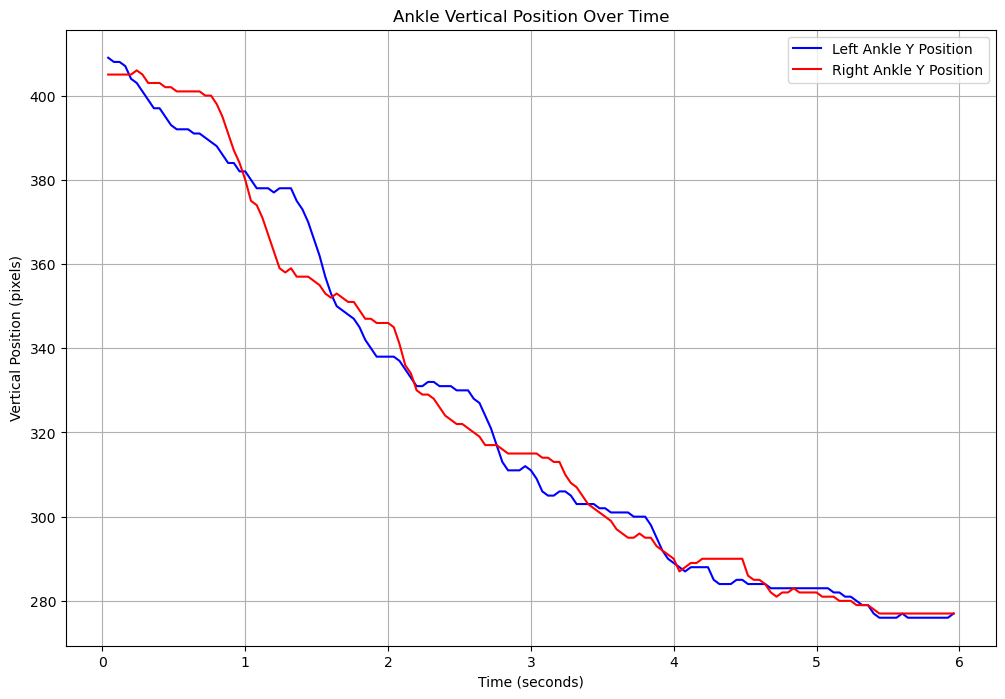

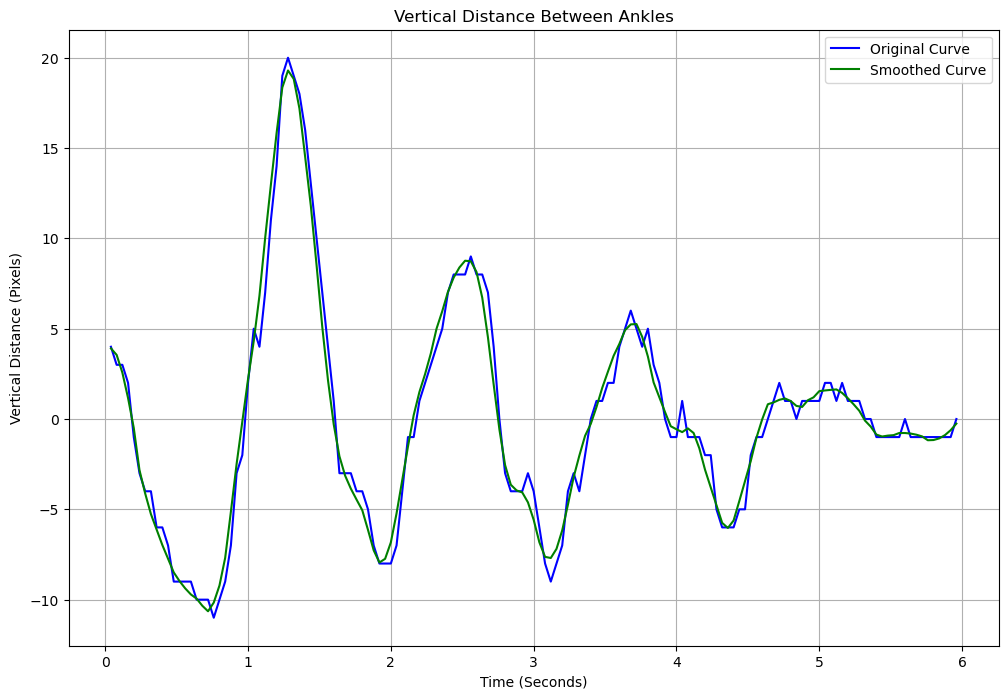

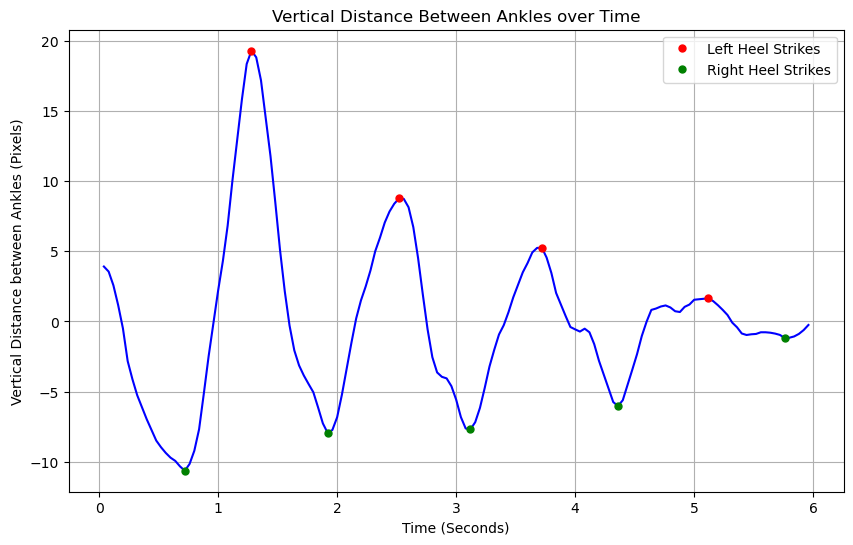

Left Heel Strikes:
 [[ 1.28    19.29375]
 [ 2.52     8.7625 ]
 [ 3.72     5.25625]
 [ 5.12     1.6375 ]]

Right Heel Strikes:
 [[  0.72    -10.64375]
 [  1.92     -7.94375]
 [  3.12     -7.69375]
 [  4.36     -6.03125]
 [  5.76     -1.175  ]]


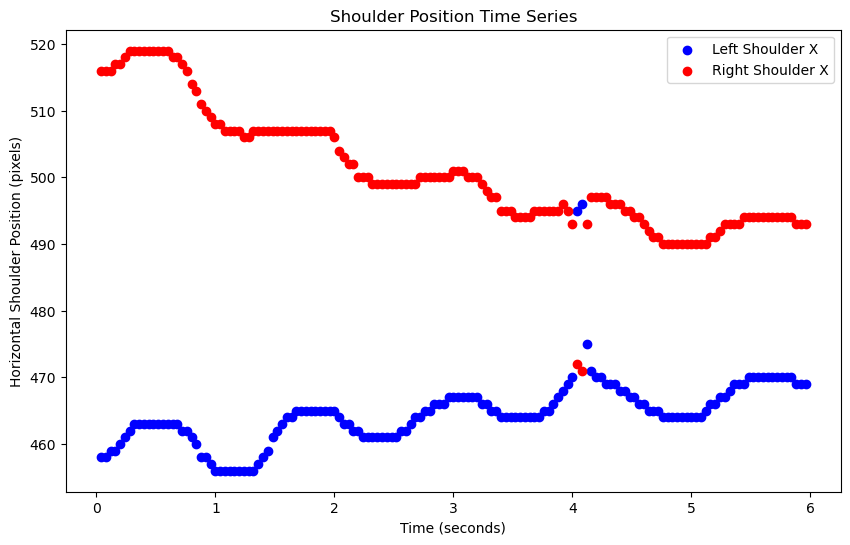

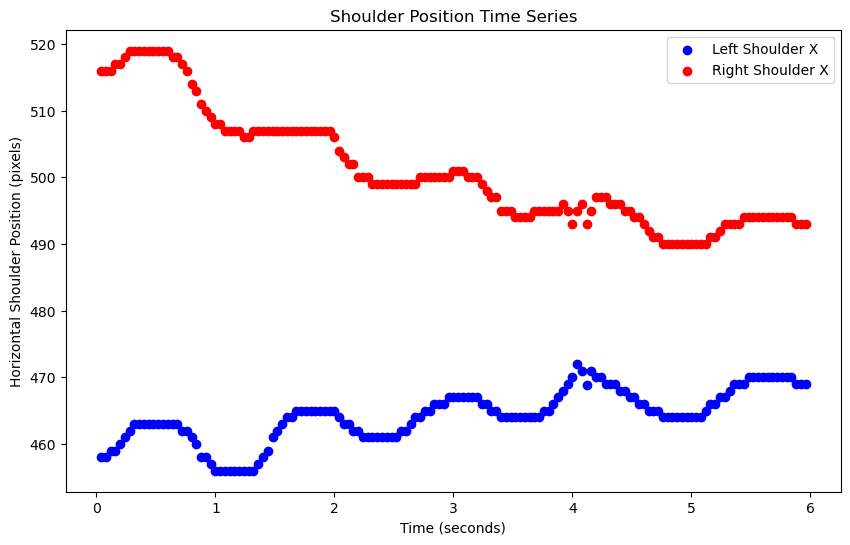

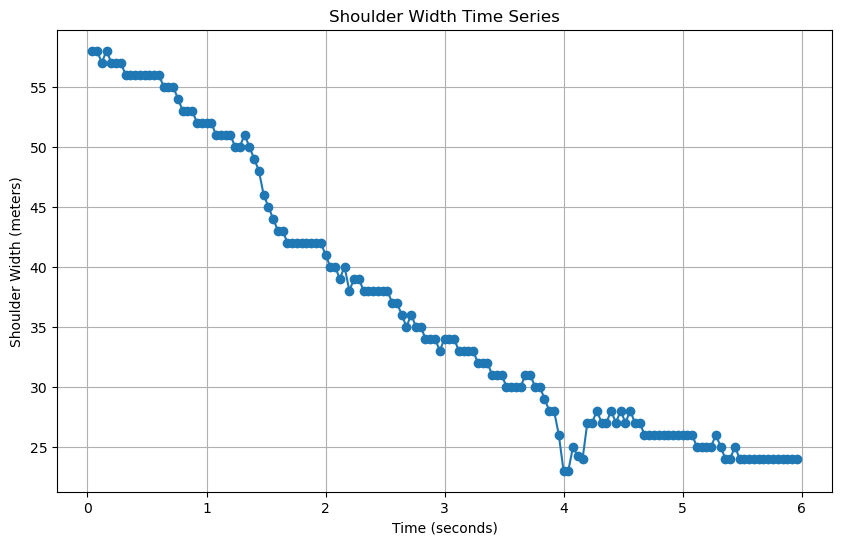

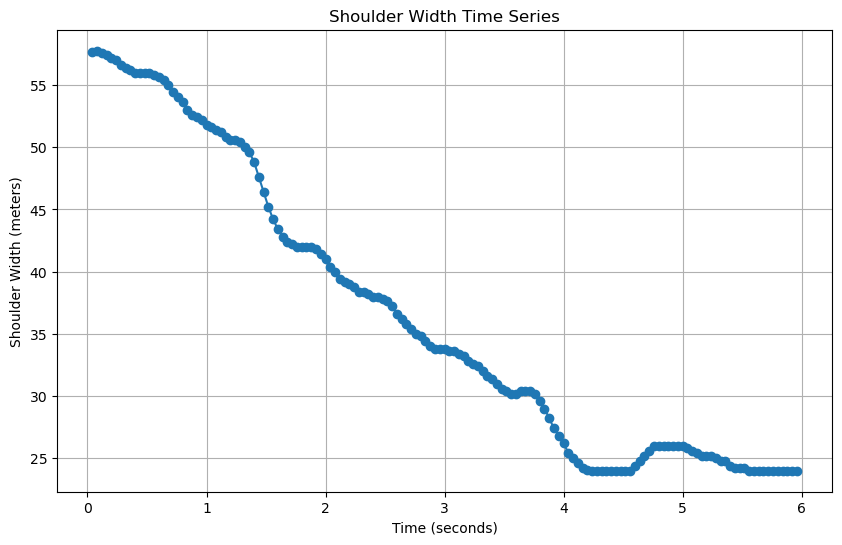

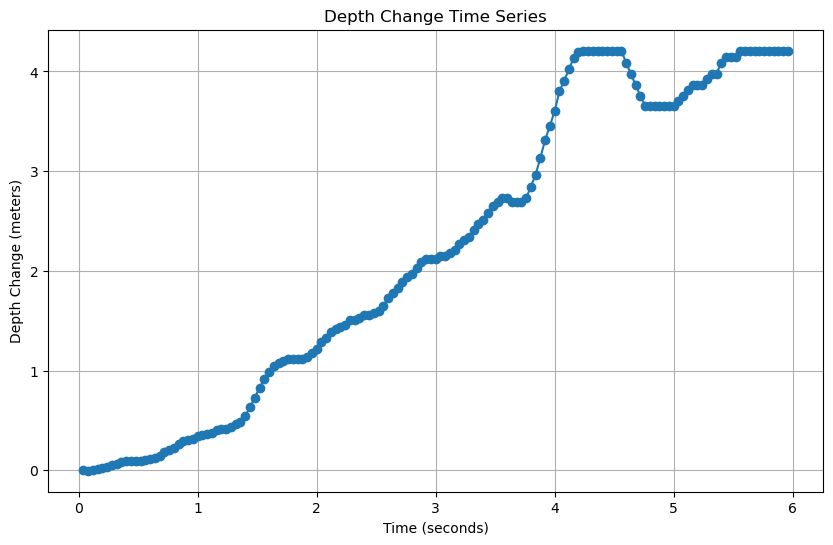

,left_step_time_mean,left_step_time_std,right_step_time_mean,right_step_time_std,left_step_length_mean,left_step_length_std,right_step_length_mean,right_step_length_std,left_gait_speed_mean,right_gait_speed_mean,left_gait_speed_std,right_gait_speed_std
0,1.28,0.08641,1.26,0.082462,1.126161,0.032441,1.007047,0.717878,0.883688,0.802466,0.062823,0.575232


In [15]:
video_folder = "frontal_videos"

# List all files in the folder
file_list = os.listdir(video_folder)

video_files = [filename for filename in file_list if filename.endswith(('.avi', '.mp4'))]

df_features = pd.DataFrame()

for video_filename in video_files:
    video_path = os.path.join(video_folder, video_filename)
   
    pose_model = PoseEstimationModel(video_path)
#     pose_model.display_video_with_keypoints()
    df = pose_model.create_keypoint_dataframe()
    time_col = df['time']
    
    # Graph initial keypoint positions
    plot_ankle_y_positions(df)
    
    window_length = 10
    polyorder = 3
    create_ankle_distance_col(df, window_length, polyorder)
    plot_orginal_smoothed_curves(df['time'], df['vertical_ankle_distance'], df['smoothed_vertical_ankle_distance'])
    
    # Calculate heel-strike and toe-off gait events
    window_size = 5
    ankle_distance_col = df['smoothed_vertical_ankle_distance']
    left_heel_strikes = find_maxima(time_col, ankle_distance_col, window_size)
    right_heel_strikes = find_minima(time_col, ankle_distance_col, window_size)
    graph_extrema(time_col, ankle_distance_col, left_heel_strikes, right_heel_strikes)
    
    print("Left Heel Strikes:\n", left_heel_strikes)
    print("\nRight Heel Strikes:\n", right_heel_strikes)
    
    # Display shoulder position
    graph_shoulders(df)
    
    # Switch misidentified left and right keypoints
    switch_left_right(df, 'left_shoulder_x','right_shoulder_x', threshold=4, window_size=10)
    graph_shoulders(df)
    
    # Add shoulder width column to the dataframe
    calc_shoulder_width(df)

    # Display shoulder width
    graph_shoulder_width(df)
    
    # Remove outliers from shoulder width data
    remove_outliers(df, 'shoulder_width', window_size=5)
    graph_shoulder_width(df)

    # Calculate the depth of change
    starting_distance = 3 # distance from camera (meters)
    calc_depth_change(df, starting_distance)
    
    # Graph the change of depth
    graph_depth_time_series(df['time'], df['depth_change'])
    
    # Calculate features
    features = calc_features(df, left_heel_strikes, right_heel_strikes)
    
    # Add the features to the DataFrame
    df_features = pd.concat([df_features, features], ignore_index=True)
    
df_features.head()